# Feature importance notebook 

This notebook examines the importance of the different features used to train the habitat and nature classification models

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import catboost as cb
import matplotlib.pyplot as plt
#from tensorflow.keras.models import load_model
import shap
# load JS visualization code to notebook
shap.initjs() 

In [4]:
from matplotlib import colors as plt_colors
# colours
df_clr = pd.read_excel(os.path.abspath("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/03_output_generation/naturtype_colours.xlsm"))

# plotting colour dict
type2clr = {row['name']: (row.R/255, row.G/255, row.B/255) for idx, row in df_clr.iterrows()}
alttype2clr = {row['alt_name']: (row.R/255, row.G/255, row.B/255) for idx, row in df_clr.iterrows()}
alttype2type = {row['alt_name']: row['name'] for idx, row in df_clr.iterrows()}
num2clr = {row['name'].split()[0].split(".")[0]: (row.R/255, row.G/255, row.B/255) for idx, row in df_clr.iterrows()}
num2type = {row['name'].split()[0].split(".")[0]: row['name'] for idx, row in df_clr.iterrows()}

# colours for colourbar
df_clr[['R', 'G', 'B']] = df_clr[['R', 'G', 'B']] / 255
df_clr['rgb'] = df_clr.apply(lambda row: (row.R, row.G, row.B), axis=1)
cmap = plt_colors.ListedColormap(df_clr.rgb)

## Naturetype model

In [7]:
# load catboost model for nature type
model_cb_nt = cb.CatBoostClassifier(task_type='GPU', devices='0:1')
model_cb_nt = model_cb_nt.load_model(os.path.abspath("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/model_cb_nt_20191202.pkl"))

# get feature names to be used in prediction order
cb_cols_nt = pd.read_csv(os.path.abspath("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/model_cb_nt_columns.csv"), 
                         header=None).values.tolist()
cb_cols_nt = [col[0] for col in cb_cols_nt]

#import hab points
folder_points = os.path.abspath("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/interim/points_hab/")
df_hab = pd.read_pickle(os.path.join(folder_points, "03_feats_embed.pkl"))

# convert NATURTYPE to NATURTYPE_full - more useful labels
df_colors = pd.read_excel(os.path.abspath("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/03_output_generation/naturtype_colours.xlsm"))
nt2ntfull = {row['alt_name']: row['name'] for idx, row in df_colors.iterrows()}
df_hab['NATURTYPE_full'] = df_hab.NATURTYPE.apply(nt2ntfull.get)

# split into features
X = df_hab.drop(columns=['NATURTYPE', 'NATURTYPE_full', 'geometry']) #'color', 'train', 
y = df_hab.NATURTYPE_full

# create train split
np.random.seed(1337)
train = np.random.rand(len(X)) < 0.8

In [9]:
X

,humidity_01,humidity_02,humidity_03,humidity_04,pressure_01,pressure_02,pressure_03,pressure_04,snow_01,snow_02,...,SOP_RGB_00,SOP_RGB_01,SOP_RGB_02,SOP_RGB_03,SOP_RGB_04,SOP_RGB_05,SOP_RGB_06,SOP_RGB_07,SOP_RGB_08,SOP_RGB_09
418,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,...,-63019.621094,-7000.878906,1396.963623,-13009.306641,-623.110291,4252.359863,-1862.316406,7182.160156,2365.167725,-1395.516602
419,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,...,-58064.414062,-8254.167969,3763.479004,-11124.343750,-2281.341309,6102.810547,-2942.083984,7210.491211,4233.330566,-3020.621582
420,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,...,-50541.289062,-9921.437500,2990.020752,-7272.276855,-1637.504761,4927.614258,-2458.744629,8395.378906,316.615723,-4212.362305
421,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,...,42511.933594,-2789.953613,-107.810181,-5435.474609,7.388428,-164.999634,-1424.600098,1392.984619,781.587036,620.124939
422,88.100861,77.895283,80.316982,89.469940,1014.530762,1014.939941,1014.913177,1014.826294,0.0,0.0,...,-46347.843750,-2432.027344,-9440.705078,-12967.349609,-7439.556152,3525.321289,-2869.209961,5375.004395,-3413.785156,1864.116699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97259,87.643105,79.737457,81.161587,87.214809,1015.498657,1014.990814,1015.122162,1015.709015,0.0,0.0,...,-47363.078125,3101.455078,2225.906250,-4929.659180,-4023.526855,4248.825684,-13415.293945,3088.911621,1780.189941,-6083.366211
97382,87.643105,79.737457,81.161587,87.214809,1015.498657,1014.990814,1015.122162,1015.709015,0.0,0.0,...,-23809.121094,-3264.176270,-9966.449219,-1706.654541,-6391.780273,-209.329407,-11474.332031,7167.889160,-2129.547119,-622.520264
97647,87.643105,79.737457,81.161587,87.214809,1015.498657,1014.990814,1015.122162,1015.709015,0.0,0.0,...,-29942.804688,190.649658,-10740.931641,-1745.818604,-3647.667236,2436.186279,-1757.522461,3674.335693,1248.551025,-2352.290039
97649,87.643105,79.737457,81.161587,87.214809,1015.498657,1014.990814,1015.122162,1015.709015,0.0,0.0,...,-43963.117188,9876.412109,-2416.403809,-3924.596191,-2389.707275,6291.996582,-6465.869629,2084.382812,1424.420898,-2997.117188


### Overall Naturetype model feature importance - shap values

In [ ]:
%%time
#overall model feature importance - shap values
#Check if Shapvalues have been calculated previously
try:
    nt_shap_values = np.load("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/shapvalues_nt.npy")
    print("Shap values loaded")
except:
    print("No nt model shapvalues loaded")
    print("Calculating nt model shapvalues..")
    nt_shap_values = model_cb_nt.get_feature_importance(cb.Pool(X[train].values,y[train].values, cat_features=['earth'],feature_names=cb_cols_nt), type='ShapValues')
    #save nt shap values
    print("Shap values calculated.")
    print("Saving shap values")
    np.save("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/shapvalues_nt.npy",nt_shap_values)

No nt model shapvalues loaded
Calculating nt model shapvalues..


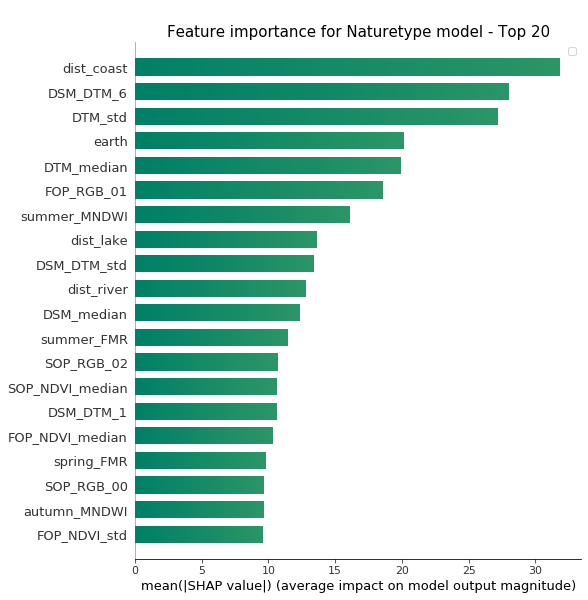

In [9]:
# summarize the effects of all the features in a multi-class barplot
original_shape = nt_shap_values.shape
shap_values_reshaped = nt_shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
#shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=X[train], class_names=y[train].unique(), plot_type=None,alpha=0.7, show=False)
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=X[train], plot_type=None,alpha=0.5, show=False, color=plt.get_cmap("summer"))
# summarize the effects of all the features in a multi-class barplot
#fig, ax = plt.subplots()
#plt.style.use('seaborn-poster')
#plt.style.use('seaborn-white')
#ax.legend(loc='upper left', frameon=False)

plt.title('\nFeature importance for Naturetype model - Top 20',fontsize=15)
plt.legend("")

In [ ]:
%%time
explainer_ = shap.TreeExplainer(model_cb_nt)
shap_values_ = explainer_.shap_values(cb.Pool(X[train].values,np.asarray(y[train].values), cat_features=['earth'],feature_names=cb_cols_nt))
shap.summary_plot(shap_values_[0], X[train].values, feature_names=cb_cols_nt)

### Area specific Naturetype model feature importance - shap values

In [9]:
%%time
#"1km_6216_577":(6217000, 6216000, 578000, 577000),
lon = 6216
lat = 577

preds = pd.read_pickle("../00_data/interim/tiles/" + str(lon) + "/" + str(lat) + "/predictions.pkl")
preds_y = preds['nattype1']

feats = pd.read_pickle("../00_data/interim/tiles/"  + str(lon) + "/" + str(lat) + "/features.pkl")
feats_X = feats[X[train].columns]

nt_shap_values_area = model_cb_nt.get_feature_importance(cb.Pool(feats_X.values,np.asarray(preds_y.values), cat_features=['earth'],feature_names=cb_cols_nt), type='ShapValues')

Wall time: 1.01 s


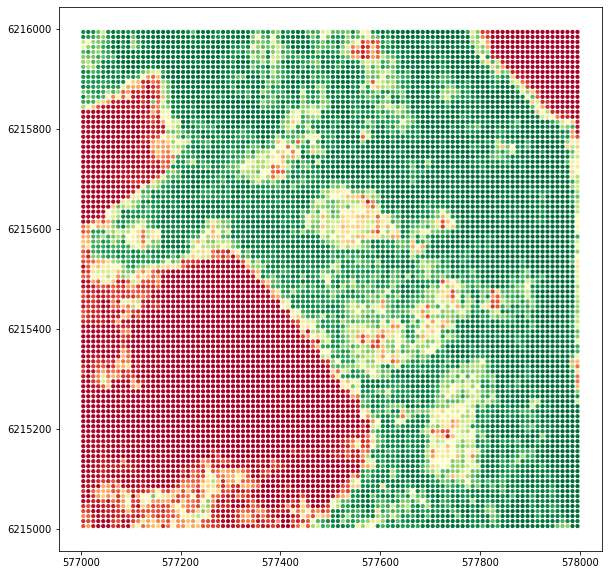

In [45]:
#test - print pred outo
plt.figure(figsize=(10,10))
preds.plot(column='habitatp', markersize=10, ax=plt.gca(), cmap='RdYlGn', vmin=0, vmax=1)
plt.show()

In [9]:
#sort nt classes by shap value index
class_inds = np.argsort([-np.abs(nt_shap_values_area[:,i,:192]).mean() for i in range(len(nt_shap_values_area[0,:,0]))])
nt_classes_sorted = np.array(model_cb_nt.classes_)[class_inds]


hab_index_lst = []
hab_names_lst = []
color_class_inds = []

for i in range(len(nt_classes_sorted)):
    if any(x in nt_classes_sorted[i] for x in preds_y.unique()):
        print(nt_classes_sorted[i])
        hab_index_lst.append(i)
        hab_names_lst.append(nt_classes_sorted[i])
        color_class_inds.append(int(df_clr[df_clr["name"]==nt_classes_sorted[i]].index.values))
        

#color map from cat list..
#cat_lst = preds_y.cat.categories.to_list()
#for i in cat_lst:
#    color_class_inds.append(int(df_clr[df_clr["name"]==i].index.values))
    
cmap = plt_colors.ListedColormap(df_clr.rgb.values[color_class_inds])

1310 - Enårig strandengsvegetation
4030 - Tør hede
6120 - Tørt kalksandsoverdrev
2190 - Klitlavning
1230 - Kystklint eller -klippe
6210 - Kalkoverdrev
5130 - Enebærkrat
7140 - Hængesæk
6230 - Surt overdrev
1330 - Strandeng
1220 - Strandvold med flerårige planter
6410 - Tidvis våd eng
9190 - Stilkegekrat
9150 - Bøg på kalk
7230 - Rigkær
9120 - Bøg på mor med kristtorn
9110 - Bøg på mor
9998 - 91D0 - Skovbevokset tørvemose
9130 - Bøg på muld
7220.2 - Skovkildevæld
9160 - Ege-blandskov
9999 - 91E0 - Elle- og askeskov


In [10]:
preds_y.value_counts()

9130 - Bøg på muld                         2550
9999 - 91E0 - Elle- og askeskov            1492
9120 - Bøg på mor med kristtorn            1329
6210 - Kalkoverdrev                        1304
7220.2 - Skovkildevæld                      778
1230 - Kystklint eller -klippe              602
9160 - Ege-blandskov                        510
1330 - Strandeng                            301
9998 - 91D0 - Skovbevokset tørvemose        249
6120 - Tørt kalksandsoverdrev               214
5130 - Enebærkrat                           188
9150 - Bøg på kalk                          101
9190 - Stilkegekrat                          92
6230 - Surt overdrev                         82
7230 - Rigkær                                80
6410 - Tidvis våd eng                        43
7140 - Hængesæk                              41
4030 - Tør hede                              14
1310 - Enårig strandengsvegetation           12
9110 - Bøg på mor                            12
1220 - Strandvold med flerårige planter 

In [54]:
len(hab_index_lst)

22

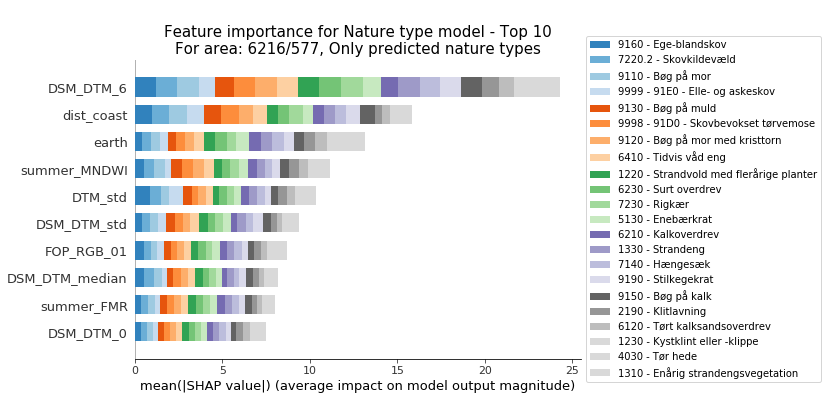

Wall time: 13.1 s


In [57]:
%%time
#plot shap values for a specific naturetype prediction of the first element in specified dict

# summarize the effects of all the features in a multi-class barplot
original_shape = nt_shap_values_area.shape
shap_values_reshaped = nt_shap_values_area.reshape(original_shape[1], original_shape[0], original_shape[-1])

plt.figure()
ax = plt.gca()

#plt.title("Shap values for naturetype model at: " + next(iter(nsew_dict)))

shap.summary_plot(list(shap_values_reshaped[(hab_index_lst),:,:-1]), df_hab[cb_cols_nt], plot_type='bar', 
                  feature_names=cb_cols_nt, color=plt.get_cmap("tab20c"), class_names=hab_names_lst, sort=True, show=False, max_display=10)

plt.title('\nFeature importance for Nature type model - Top 10\nFor area: ' + str(lon) + "/" + str(lat)+", Only predicted nature types",fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

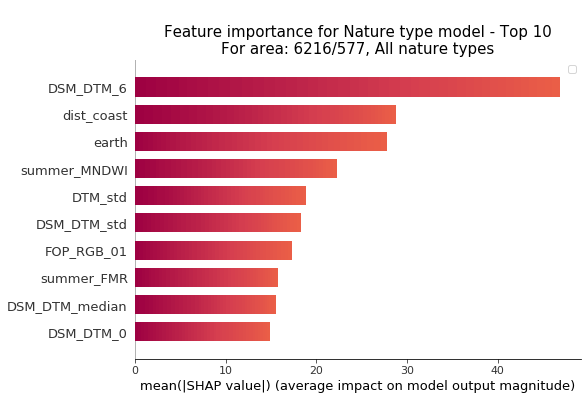

Wall time: 12.4 s


In [46]:
%%time
#plot shap values for a specific naturetype prediction of the first element in specified dict

# summarize the effects of all the features in a multi-class barplot
original_shape = nt_shap_values_area.shape
shap_values_reshaped = nt_shap_values_area.reshape(original_shape[1], original_shape[0], original_shape[-1])

plt.figure()
ax = plt.gca()

#plt.title("Shap values for naturetype model at: " + next(iter(nsew_dict)))

shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), df_hab[cb_cols_nt], plot_type='bar', 
                  feature_names=cb_cols_nt, color=plt.get_cmap("Spectral"), sort=True, show=False, max_display=10)

plt.title('\nFeature importance for Nature type model - Top 10\nFor area: ' + str(lon) + "/" + str(lat) + ", All nature types",fontsize=15)
plt.legend("")
plt.show()

In [47]:
# Make txt file of mapped jordartscode to jordartstype
# import as dict and print jordartstypen

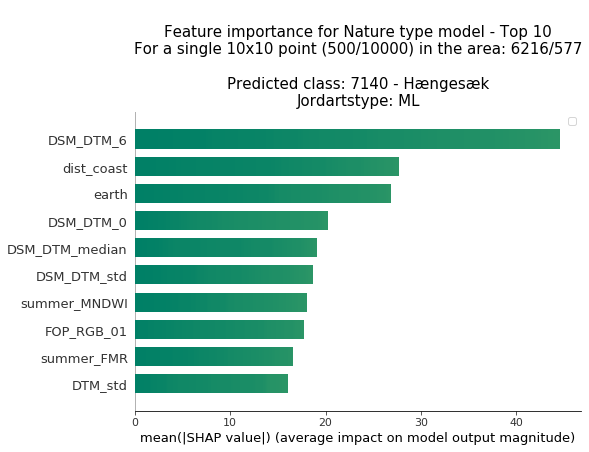

Wall time: 7.01 s


,feature,feature_importance_vals,actual_vals
88,DSM_DTM_6,1.013238,0
43,dist_coast,0.630331,1024
42,earth,0.610971,ML
82,DSM_DTM_0,0.460503,482
100,DSM_DTM_median,0.433918,0
101,DSM_DTM_std,0.425685,1.30481
117,summer_MNDWI,0.409222,-0.652722
173,FOP_RGB_01,0.402909,6052.76
114,summer_FMR,0.378016,0.342599
99,DTM_std,0.365280,0


In [76]:
%%time
#plot shap values for a specific naturetype prediction of the first element in specified dict
punkt = 500
punkt_end = punkt+1


# summarize the effects of all the features in a multi-class barplot
original_shape = nt_shap_values_area.shape
shap_values_reshaped = nt_shap_values_area.reshape(original_shape[1], original_shape[0], original_shape[-1])

plt.figure()
ax = plt.gca()

#plt.title("Shap values for naturetype model at: " + next(iter(nsew_dict)))

shap.summary_plot(list(shap_values_reshaped[:,punkt:punkt_end,:-1]), df_hab[cb_cols_nt], plot_type='bar', 
                  feature_names=cb_cols_nt, color=plt.get_cmap("summer"), sort=True, show=False, max_display=10)

plt.title('\nFeature importance for Nature type model - Top 10\nFor a single 10x10 point ('+str(punkt)+'/'+str(len(preds_y))+') in the area: ' + str(lon) + "/" + str(lat) +'\n\nPredicted class: '+str(preds_y[punkt])
          +'\nJordartstype: '+ feats_X['earth'].iloc[punkt],fontsize=15)
plt.legend("")
plt.show()

vals= np.abs(list(shap_values_reshaped[:,punkt:punkt_end,:-1])).mean(0)

feature_importance = pd.DataFrame(list(zip(X[train].columns, sum(vals))), columns=['feature','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance[:10]

act_vals = []
for i in feature_importance["feature"]:
    act_vals.append(feats_X[i].iloc[punkt])
    
feature_importance["actual_vals"] = act_vals

feature_importance.head(10)

#output x y koordinater - disse er rundet op..
#tilføj output ifa earth typen -> oversæt til den forklarende colonne fra earth layer i qgis
#shapværdien + den reelle værdi af af top 10 features 

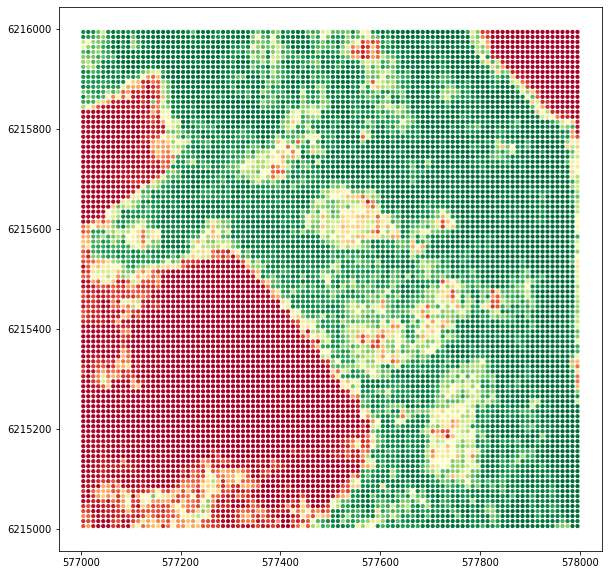

In [50]:
#test - print pred outo
plt.figure(figsize=(10,10))
preds.plot(column='habitatp', markersize=10, ax=plt.gca(), cmap='RdYlGn', vmin=0, vmax=1)
plt.show()

In [27]:
%%time
explainer_ = shap.TreeExplainer(model_cb_nt)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Wall time: 41min 47s


In [34]:
feats_X.iloc[punkt]

humidity_01    87.5985
humidity_02    77.2545
humidity_03    81.2039
humidity_04    90.5008
pressure_01    1014.12
                ...   
SOP_RGB_05     -2282.1
SOP_RGB_06     745.367
SOP_RGB_07     1173.86
SOP_RGB_08     231.873
SOP_RGB_09      2194.7
Name: 500, Length: 192, dtype: object

In [35]:
X[train].iloc[punkt]

humidity_01    89.2733
humidity_02    80.7702
humidity_03    81.6879
humidity_04    89.7997
pressure_01    1013.85
                ...   
SOP_RGB_05     1638.22
SOP_RGB_06    -6934.46
SOP_RGB_07     8300.38
SOP_RGB_08    -3129.23
SOP_RGB_09    -281.066
Name: 8580, Length: 192, dtype: object

In [37]:
punkt = 500

indices = [i for i, s in enumerate(model_cb_nt.classes_) if preds_y.iloc[punkt] in s]

shap_values = explainer_.shap_values([feats_X.iloc[punkt]])


print(preds_y.iloc[punkt])
display(shap.force_plot(explainer_.expected_value[indices[0]], shap_values[indices[0]], feats_X.iloc[punkt]))

7140 - Hængesæk


In [43]:
model_cb_nt.classes_[20]

'4030 - Tør hede'

In [41]:
punkt = 500

indices = [i for i, s in enumerate(model_cb_nt.classes_) if preds_y.iloc[punkt] in s]

shap_values = explainer_.shap_values([feats_X.iloc[punkt]])


print(preds_y.iloc[punkt])
display(shap.force_plot(explainer_.expected_value[20], shap_values[20], feats_X.iloc[punkt]))

7140 - Hængesæk


In [ ]:
# visualize the training set predictions
expected_value = nt_shap_values_area[0,-1]
example_num = 0
print(y[~train].iloc[example_num])
shap.force_plot(expected_value[example_num], nt_shap_values_area[example_num], feature_names=cb_cols_nt)

## Habitat model

In [22]:
# load catboost model for hab/non-hab
model_cb_hab = cb.CatBoostClassifier(task_type='GPU', devices='0:1')
model_cb_hab = model_cb_hab.load_model(os.path.abspath("../00_data/models/phase3/catboost/model_cb_hab_20191202.pkl"))

# get feature names to be used in prediction order
cb_cols_hab = pd.read_csv(os.path.abspath("../00_data/models/phase3/catboost/model_cb_hab_columns.csv"), 
                          header=None).values.tolist()
cb_cols_hab = [col[0] for col in cb_cols_hab]

# import p3 and non-hab points
df_nonhab = pd.read_pickle("../00_data/interim/points_nonhab/03_feats_embed.pkl")
df_nonhab['label'] = 'ikke-habitat'
df_p3 = pd.read_pickle("../00_data/interim/points_p3/03_feats_embed.pkl")
df_p3['label'] = 'p3'
df_hab['label'] = 'habitat'

# combine all points (used for non-hab model training)
df = pd.concat([df_nonhab, df_hab, df_p3], sort=False).reset_index(drop=True)

# split into features
X = df.drop(columns=['NATURTYPE', 'NATURTYPE_full','geometry', 'label']) 
y = df.label
X.shape

import random
random.seed(1337)

# create train/test divide
train = np.random.rand(len(X)) < 0.8

In [23]:
%%time
#overall model feature importance - shap values

try:
    hab_shap_values = np.load("../00_data/models/phase3/catboost/shapvalues_hab.npy")
    print("Shap values loaded")
except:
    print("No hab model shapvalues loaded")
    print("Calculating hab model shapvalues..")
    hab_shap_values = model_cb_hab.get_feature_importance(cb.Pool(X[train].values,y[train].values, cat_features=['earth'],feature_names=cb_cols_nt), type='ShapValues')
    #save nt shap values
    print("Shap values calculated.")
    print("Saving shap values")
    np.save("../00_data/models/phase3/catboost/shapvalues_hab.npy",hab_shap_values)

Shap values loaded
CPU times: user 14.8 ms, sys: 590 ms, total: 605 ms
Wall time: 10.2 s


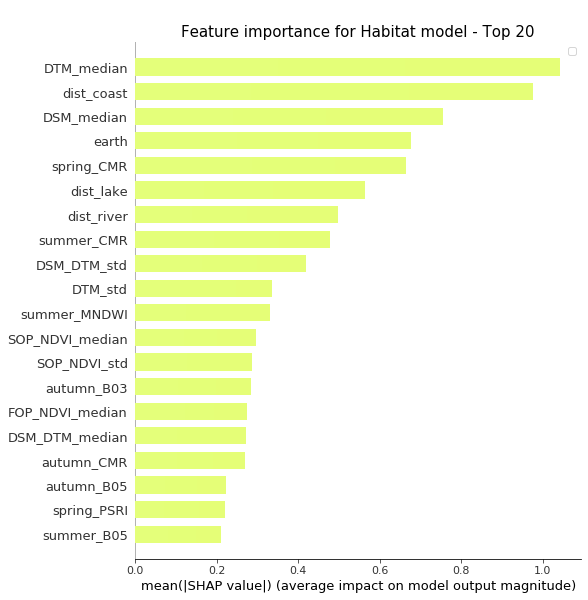

In [24]:
# summarize the effects of all the features in a multi-class barplot
original_shape = hab_shap_values.shape
shap_values_reshaped = hab_shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap.summary_plot(list(shap_values_reshaped[:,:,:-1]), features=X[train], plot_type=None,alpha=0.5, show=False, color=plt.get_cmap("Wistia"))


plt.title('\nFeature importance for Habitat model - Top 20',fontsize=15)
plt.legend("")

<BarContainer object of 192 artists>

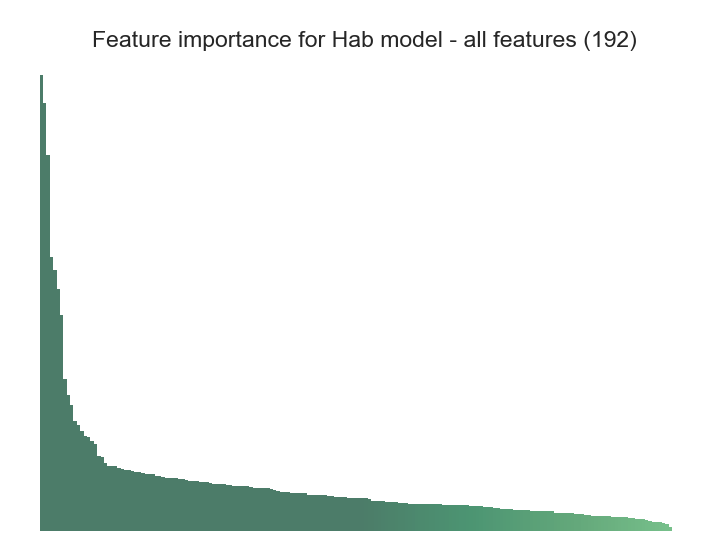

In [16]:
plt.style.use('seaborn-poster')
plt.style.use('seaborn-white')
feat_imp_sorted, train_data_columns_sorted = zip(*sorted(zip(feat_imp, list(X[train])),reverse=True))
cmap = plt.get_cmap("YlGn")
colors = cmap(np.arange(350,130,-1))
plt.title('\nFeature importance for Hab model - all features (192)',fontsize=23)
plt.box(None)
plt.axis('off')

plt.bar(train_data_columns_sorted[:],width=1,color=colors, alpha=0.7, height=feat_imp_sorted[:])#temp[::-1].sort()  -np.sort(-a)